In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [ ]:
DATA_PATH = Path('/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/FGNET/images')
ALIGN_FACE_PATH = DATA_PATH.resolve().parent / 'align_face_v2'

In [ ]:
%cd /content/drive/My\ Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET
# !git clone https://github.com/TropComplique/mtcnn-pytorch.git

/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET


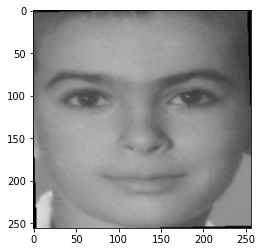

In [ ]:
exam_img = Image.open(os.path.join(str(DATA_PATH), '001A08.JPG')).convert('RGB')
plt.imshow(exam_img)
plt.show()

In [ ]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable
from mtcnn_pytorch.src.get_nets import PNet, RNet, ONet
from mtcnn_pytorch.src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from mtcnn_pytorch.src.first_stage import run_first_stage
from mtcnn_pytorch.src.align_trans import get_reference_facial_points, warp_and_crop_face
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MTCNN():
    def __init__(self):
        self.pnet = PNet().to(device)
        self.rnet = RNet().to(device)
        self.onet = ONet().to(device)
        self.pnet.eval()
        self.rnet.eval()
        self.onet.eval()
        self.refrence = get_reference_facial_points(default_square= True)
        
    def align(self, img):
        _, landmarks = self.detect_faces(img)
        facial5points = [[landmarks[0][j],landmarks[0][j+5]] for j in range(5)]
        warped_face = warp_and_crop_face(np.array(img), facial5points, self.refrence, crop_size=(112,112))
        return Image.fromarray(warped_face)
    
    def align_multi(self, img, limit=None, min_face_size=30.0):
        boxes, landmarks = self.detect_faces(img, min_face_size)
        if limit:
            boxes = boxes[:limit]
            landmarks = landmarks[:limit]
        faces = []
        for landmark in landmarks:
            facial5points = [[landmark[j],landmark[j+5]] for j in range(5)]
            warped_face = warp_and_crop_face(np.array(img), facial5points, self.refrence, crop_size=(112,112))
            faces.append(Image.fromarray(warped_face))
        return boxes, faces

    def detect_faces(self, image, min_face_size=20.0,
                     thresholds=[0.6, 0.7, 0.8],
                     nms_thresholds=[0.7, 0.7, 0.7]):
        """
        Arguments:
            image: an instance of PIL.Image.
            min_face_size: a float number.
            thresholds: a list of length 3.
            nms_thresholds: a list of length 3.

        Returns:
            two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
            bounding boxes and facial landmarks.
        """

        # BUILD AN IMAGE PYRAMID
        width, height = image.size
        min_length = min(height, width)

        min_detection_size = 12
        factor = 0.707  # sqrt(0.5)

        # scales for scaling the image
        scales = []

        # scales the image so that
        # minimum size that we can detect equals to
        # minimum face size that we want to detect
        m = min_detection_size/min_face_size
        min_length *= m

        factor_count = 0
        while min_length > min_detection_size:
            scales.append(m*factor**factor_count)
            min_length *= factor
            factor_count += 1

        # STAGE 1

        # it will be returned
        bounding_boxes = []

        with torch.no_grad():
            # run P-Net on different scales
            for s in scales:
                boxes = run_first_stage(image, self.pnet, scale=s, threshold=thresholds[0])
                bounding_boxes.append(boxes)

            # collect boxes (and offsets, and scores) from different scales
            bounding_boxes = [i for i in bounding_boxes if i is not None]
            bounding_boxes = np.vstack(bounding_boxes)

            keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
            bounding_boxes = bounding_boxes[keep]

            # use offsets predicted by pnet to transform bounding boxes
            bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
            # shape [n_boxes, 5]

            bounding_boxes = convert_to_square(bounding_boxes)
            bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

            # STAGE 2

            img_boxes = get_image_boxes(bounding_boxes, image, size=24)
            img_boxes = torch.FloatTensor(img_boxes).to(device)

            output = self.rnet(img_boxes)
            offsets = output[0].cpu().data.numpy()  # shape [n_boxes, 4]
            probs = output[1].cpu().data.numpy()  # shape [n_boxes, 2]

            keep = np.where(probs[:, 1] > thresholds[1])[0]
            bounding_boxes = bounding_boxes[keep]
            bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
            offsets = offsets[keep]

            keep = nms(bounding_boxes, nms_thresholds[1])
            bounding_boxes = bounding_boxes[keep]
            bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
            bounding_boxes = convert_to_square(bounding_boxes)
            bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

            # STAGE 3

            img_boxes = get_image_boxes(bounding_boxes, image, size=48)
            if len(img_boxes) == 0: 
                return [], []
            img_boxes = torch.FloatTensor(img_boxes).to(device)
            output = self.onet(img_boxes)
            landmarks = output[0].cpu().data.numpy()  # shape [n_boxes, 10]
            offsets = output[1].cpu().data.numpy()  # shape [n_boxes, 4]
            probs = output[2].cpu().data.numpy()  # shape [n_boxes, 2]

            keep = np.where(probs[:, 1] > thresholds[2])[0]
            bounding_boxes = bounding_boxes[keep]
            bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
            offsets = offsets[keep]
            landmarks = landmarks[keep]

            # compute landmark points
            width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
            height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
            xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
            landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
            landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

            bounding_boxes = calibrate_box(bounding_boxes, offsets)
            keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
            bounding_boxes = bounding_boxes[keep]
            landmarks = landmarks[keep]

        return bounding_boxes, landmarks

In [ ]:
mtcnn = MTCNN()

In [ ]:
def preprocess_images(img_dir, save_dir):
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)

  for idx, img in enumerate(sorted(os.listdir(img_dir))):
    path = os.path.join(img_dir, img)
    name = img.split(os.sep)[-1]
    face = Image.open(path).convert('RGB')
    boxces, align_faces = mtcnn.align_multi(face, limit=1)

    if len(align_faces) == 0:
      print('Cannot extract face from {}'.format(name))
      resize_face = align_faces[0].resize((256, 256))
      resize_face.save(os.path.join(save_dir, name))
      print('{} finish'.format(name))
      continue

    resize_face = align_faces[0].resize((256, 256))
    resize_face.save(os.path.join(save_dir, name))
    print('{} finish'.format(name))
  print('Done')

In [ ]:
preprocess_images(DATA_PATH, ALIGN_FACE_PATH)

/content/drive/MyDrive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/mtcnn_pytorch/src/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
/content/drive/MyDrive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/mtcnn_pytorch/src/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/drive/MyDrive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/mtcnn_pytorch/src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/content/drive/MyDrive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/mtcnn_pytorch/src/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
mtcnn_pytorch/src/matlab_cp2tform.py:90: Fut

001A02.JPG finish
001A05.JPG finish
001A08.JPG finish
001A10.JPG finish
001A14.JPG finish
001A16.JPG finish
001A18.JPG finish
001A19.JPG finish
001A22.JPG finish
001A28.JPG finish
001A29.JPG finish
001A33.JPG finish
001A40.JPG finish
001A43a.JPG finish
001A43b.JPG finish
002A03.JPG finish
002A04.JPG finish
002A05.JPG finish
002A07.JPG finish
002A12.JPG finish
002A15.JPG finish
002A16.JPG finish
002A18.JPG finish
002A20.JPG finish
002A21.JPG finish
002A23.JPG finish
002A26.JPG finish
002A29.JPG finish
002A31.JPG finish
002A36.JPG finish
002A38.JPG finish
003A18.JPG finish
003A20.JPG finish
003A23.JPG finish
003A25.JPG finish
003A35.JPG finish
003A38.JPG finish
003A47.JPG finish
003A49.JPG finish
003A51.JPG finish
003A58.JPG finish
003A60.JPG finish
003A61.JPG finish
004A19.JPG finish
004A21.JPG finish
004A26.JPG finish
004A28.JPG finish
004A30.JPG finish
004A37.JPG finish
004A40.JPG finish
004A48.JPG finish
004A51.JPG finish
004A53.JPG finish
004A62.JPG finish
004A63.JPG finish
005A18.J

In [ ]:
cant_extract_img = list(set(os.listdir(DATA_PATH)) - set(os.listdir(ALIGN_FACE_PATH)))

In [ ]:
cant_extract_img

['050A00.JPG', '033A02.JPG', '014A03.JPG']

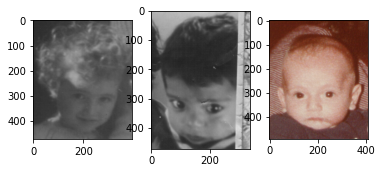

In [ ]:
for i, img in enumerate(sorted(cant_extract_img)):
  im = Image.open(os.path.join(str(DATA_PATH), img)).convert('RGB')
  im = np.asarray(im).astype('uint8')
  plt.subplot(1, 3, i+1)
  plt.imshow(im)
plt.show()